In [2]:
import sys 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Read the data

In [3]:
df_demo = pd.read_csv('user_demographics.csv')                        # Read the demographics Data
df_demo['age'] = df_demo['age'].fillna(df_demo['age'].mean())
df_demo = df_demo.drop(columns=['province'])
df_demo = pd.get_dummies(df_demo,columns=['gender'],dummy_na=False)
df_demo.head()

,userId,age,registeredMonthCnt,followCnt,level,gender_female,gender_male,gender_unknown
0,MCPCHCMCHCIC,21.000000,80.0,44.0,9.0,0,1,0
1,NCOCKCPCMCGCGC,23.000000,76.0,59.0,8.0,0,1,0
2,PCKCOCMCGCGCHCKC,21.507805,69.0,21.0,7.0,0,0,0
3,MCICHCKCKCGCMCIC,21.507805,66.0,38.0,10.0,0,0,0
4,NCJCHCPCNCICNCNC,20.000000,57.0,29.0,8.0,0,1,0


In [81]:
df_impression_s = pd.read_csv('impression_data.csv',index_col=False)  # Read the Action Data
len(df_impression_s)

57750395

In [82]:
df_impression_c = pd.merge(df_impression_s,df_demo,how='inner',on='userId') # Match Action with Demographical Data
len(df_impression_c)

57750012

In [83]:
# The major sample table ready for further sampling
df_impression_c.head()

,detailMlogInfoList,dt,impressPosition,impressTime,isClick,isComment,isIntoPersonalHomepage,isShare,isViewComment,isLike,mlogId,mlogViewTime,userId,age,registeredMonthCnt,followCnt,level,gender_female,gender_male,gender_unknown
0,NaN,29,1,1574980776000,0,0,0,0,0,0,NCLCPCJCOCGCJC,NaN,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
1,NaN,25,6,1574684613000,0,0,0,0,0,0,KCNCOCNCMCOCMC,NaN,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
2,"[{'isZan': '0', 'isComment': '0', 'mlogId': 'K...",25,1,1574684241000,1,0,0,0,0,0,NCHCGCICLCPCGC,2.98,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
3,NaN,15,3,1573767973000,0,0,0,0,0,0,PCNCNCPCICLCGC,NaN,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
4,NaN,15,2,1573767973000,0,0,0,0,0,0,NCHCICPCOCLCOC,NaN,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0


In [84]:
df_impression_c['mlogViewTime'] = df_impression_c['mlogViewTime'].fillna(0)
df_impression_c.head()

,detailMlogInfoList,dt,impressPosition,impressTime,isClick,isComment,isIntoPersonalHomepage,isShare,isViewComment,isLike,mlogId,mlogViewTime,userId,age,registeredMonthCnt,followCnt,level,gender_female,gender_male,gender_unknown
0,NaN,29,1,1574980776000,0,0,0,0,0,0,NCLCPCJCOCGCJC,0.00,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
1,NaN,25,6,1574684613000,0,0,0,0,0,0,KCNCOCNCMCOCMC,0.00,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
2,"[{'isZan': '0', 'isComment': '0', 'mlogId': 'K...",25,1,1574684241000,1,0,0,0,0,0,NCHCGCICLCPCGC,2.98,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
3,NaN,15,3,1573767973000,0,0,0,0,0,0,PCNCNCPCICLCGC,0.00,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0
4,NaN,15,2,1573767973000,0,0,0,0,0,0,NCHCICPCOCLCOC,0.00,PCNCGCGCLCOCOCOCJCGC,22.0,21.0,2.0,6.0,0,1,0


In [155]:
df_impression = df_impression_c.sample(n=250000)                # Try on small sample of the data first 
df_impression.head()
len(df_impression)

250000

In [156]:
df_change = df_impression.drop_duplicates(subset=['userId'])   # To make sure all the users' action record that we're gonna use has its corresponding demographic records
len(df_change)                                                 # Only choose the users that have both info. 

173121

In [157]:
df_name_rk = df_impression.value_counts(subset='userId')
df_name_rk = df_name_rk.to_frame()                      

df_name_rk = df_name_rk.rename(columns={0:'userFrequency'})
df_name_rk.head()
df_name_rk.describe()

,userFrequency
count,173121.000000
mean,1.444077
std,1.568556
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,113.000000


In [158]:
# Drop users who only have 2 or less record. Because their stastics for training and testing are too random
df_name_rk_1 = df_name_rk[df_name_rk['userFrequency']<=4] 
dict = df_name_rk_1.to_dict('index')
a = list(dict.keys())
df_impression = df_impression[~df_impression['userId'].isin(a)]
len(df_impression)


37305

In [159]:
df_user_name_arr = df_impression['userId'].unique()
len(df_user_name_arr)

4567

In [160]:
# According to the dataset description, this is the nested data hidden in the ['detailMlogInfoList']
extra_view_time = []
count = 0 # Track the progress of the transition
for index,row in df_impression.iterrows():
    if isinstance(df_impression['detailMlogInfoList'][index],float):
        extra_view_time.append(0)
    else:
        str_1 = df_impression['detailMlogInfoList'][index]
        substr = 'mlogViewTime'
        res_start = [i for i in range(len(str_1)) if str_1.startswith(substr, i)]
        # print("The start indices of the substrings are : " + str(res_start))

        substr = 'isShare'
        res_end = [i for i in range(len(str_1)) if str_1.startswith(substr, i)]
        # print("The start indices of the substrings are : " + str(res_end))

        num_to_add = 0
        for IndexInList in range(len(res_start)):
            start = res_start[IndexInList] + 16
            end = res_end[IndexInList] - 4
            num_to_add+= float(str_1[start:end])
        # print(num_to_add)
        extra_view_time.append(num_to_add)
    count+=1
    if count%100 == 0:
        print(count,end=',')

100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000,5100,5200,5300,5400,5500,5600,5700,5800,5900,6000,6100,6200,6300,6400,6500,6600,6700,6800,6900,7000,7100,7200,7300,7400,7500,7600,7700,7800,7900,8000,8100,8200,8300,8400,8500,8600,8700,8800,8900,9000,9100,9200,9300,9400,9500,9600,9700,9800,9900,10000,10100,10200,10300,10400,10500,10600,10700,10800,10900,11000,11100,11200,11300,11400,11500,11600,11700,11800,11900,12000,12100,12200,12300,12400,12500,12600,12700,12800,12900,13000,13100,13200,13300,13400,13500,13600,13700,13800,13900,14000,14100,14200,14300,14400,14500,14600,14700,14800,14900,15000,15100,15200,15300,15400,15500,15600,15700,15800,15900,16000,16100,16200,16300,16400,16500,16600,16700,16800,16900,17000,17100,17200,17300,17400,17500,17600,17700,17800,17900,18000,18100,18200,18300,18400,1850

In [161]:
df_impression['extra_view_time'] = extra_view_time

In [162]:
df_impression.head()

,detailMlogInfoList,dt,impressPosition,impressTime,isClick,isComment,isIntoPersonalHomepage,isShare,isViewComment,isLike,...,mlogViewTime,userId,age,registeredMonthCnt,followCnt,level,gender_female,gender_male,gender_unknown,extra_view_time
39382694,NaN,5,242,1572931788000,0,0,0,0,0,0,...,0.0,KCGCNCJCNCICPCKCGC,29.000000,30.0,9.0,7.0,0,1,0,0.0
46645093,NaN,27,100,1574848042000,0,0,0,0,0,0,...,0.0,NCOCLCMCNCOCJCPCKC,22.000000,39.0,0.0,9.0,0,1,0,0.0
1110192,NaN,30,15,1575118493000,0,0,0,0,0,0,...,0.0,KCOCJCOCLCGCOCICLC,15.000000,35.0,67.0,8.0,0,1,0,0.0
34883011,NaN,15,3,1573796412000,0,0,0,0,0,0,...,0.0,PCLCKCPCKCJCKCLCMCNC,25.000000,16.0,4.0,7.0,0,1,0,0.0
602659,NaN,15,11,1573820491000,0,0,0,0,0,0,...,0.0,KCLCPCGCNCICJCKCHC,21.507805,32.0,18.0,7.0,0,0,0,0.0


# Define and calculate the features

In [163]:
# Caculate the probability of previous actions
Avg_Cli = []
Avg_Com = []
Avg_IPH = []
Avg_S = []
Avg_VC = []
Avg_L = []
Avg_View_Time = []
Avg_Extra_View_Time = []

Age = []
G_female = []
G_male  = []
G_U = []
Level = []
followCnt = []
R_Month = []
p = 0

for i in df_user_name_arr:
    # Fetch all records of a specific users
    df_i = df_impression.loc[df_impression['userId'] == i]
    # Cut them in half, generate features from the first half and target from the second half.
    df_i_first_half = df_i[:int(len(df_i)/2)]
    df_i_second_half = df_i[int(len(df_i)/2):]
    
    # First half for features
    df_ii = df_i_first_half.describe().loc['mean']
    Avg_Com.append(df_ii['isComment'])
    Avg_IPH.append(df_ii['isIntoPersonalHomepage'])
    Avg_S.append(df_ii['isShare'])
    Avg_VC.append(df_ii['isViewComment'])
    Avg_L.append(df_ii['isLike'])
    Avg_View_Time.append(df_ii['mlogViewTime'])
    Avg_Extra_View_Time.append(df_ii['extra_view_time'])
    
    # Second half for target
    df_iii = df_i_second_half.describe().loc['mean']
    Avg_Cli.append(df_iii['isClick'])

    # Append the demographics data
    Age.append(df_ii['age'])
    G_female.append(df_ii['gender_female'])
    G_male.append(df_ii['gender_male'])
    G_U.append(df_ii['gender_unknown'])
    Level.append(df_ii['level'])
    followCnt.append(df_ii['followCnt'])
    R_Month.append(df_ii['registeredMonthCnt'])

    #tracking the progress of processing
    p += 1
    if p%100 == 0:
        print(p,end=',')


100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,

In [164]:
# Produce the dataframe that will be used for classfication tasks
df_user = pd.DataFrame(df_user_name_arr,columns=['userId'])
df_user['Avg_Cli'] = Avg_Cli
df_user['Avg_IPH'] = Avg_IPH
df_user['Avg_Com'] = Avg_Com
df_user['Avg_S'] = Avg_S
df_user['Avg_VC'] = Avg_VC
df_user['Avg_L'] = Avg_L
df_user['Avg_View_Time'] = Avg_View_Time
df_user['Avg_Extra_View_Time'] = Avg_Extra_View_Time
df_user['Age'] = Age
df_user['G_female'] = G_female
df_user['G_male'] = G_male
df_user['G_U'] = G_U
df_user['Level'] = Level
df_user['followCnt'] =followCnt
df_user['R_Month'] =R_Month

df_user.describe()

,Avg_Cli,Avg_IPH,Avg_Com,Avg_S,Avg_VC,Avg_L,Avg_View_Time,Avg_Extra_View_Time,Age,G_female,G_male,G_U,Level,followCnt,R_Month
count,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000
mean,0.075899,0.000224,0.000073,0.000544,0.013854,0.003787,1.895520,5.023042,20.984079,0.248084,0.325159,0.011824,6.649004,31.659514,25.040508
std,0.143448,0.007041,0.004932,0.013438,0.068277,0.035842,6.075721,48.656384,2.887529,0.431948,0.468485,0.108105,1.660942,67.053070,14.561720
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,6.000000,5.000000,13.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.507805,0.000000,0.000000,0.000000,7.000000,13.000000,26.000000
75%,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.507805,0.000000,1.000000,0.000000,8.000000,32.000000,35.000000
max,1.000000,0.333333,0.333333,0.500000,0.666667,0.500000,136.805000,1867.626667,34.000000,1.000000,1.000000,1.000000,10.000000,1873.000000,80.000000


In [165]:
df_user['Avg_View_Time'] = df_user['Avg_View_Time'] + df_user ['Avg_Extra_View_Time']
df_user = df_user.drop(columns=['Avg_Extra_View_Time'])
df_user.describe()

,Avg_Cli,Avg_IPH,Avg_Com,Avg_S,Avg_VC,Avg_L,Avg_View_Time,Age,G_female,G_male,G_U,Level,followCnt,R_Month
count,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000
mean,0.075899,0.000224,0.000073,0.000544,0.013854,0.003787,6.918562,20.984079,0.248084,0.325159,0.011824,6.649004,31.659514,25.040508
std,0.143448,0.007041,0.004932,0.013438,0.068277,0.035842,51.092828,2.887529,0.431948,0.468485,0.108105,1.660942,67.053070,14.561720
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,6.000000,5.000000,13.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.507805,0.000000,0.000000,0.000000,7.000000,13.000000,26.000000
75%,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.507805,0.000000,1.000000,0.000000,8.000000,32.000000,35.000000
max,1.000000,0.333333,0.333333,0.500000,0.666667,0.500000,1918.290000,34.000000,1.000000,1.000000,1.000000,10.000000,1873.000000,80.000000


# Redefine Classification Target to 0/1

In [166]:
df_user['Active'] = np.where(df_user['Avg_Cli'] > 0, 1, 0)
df_user.head()

df_user.describe()


,Avg_Cli,Avg_IPH,Avg_Com,Avg_S,Avg_VC,Avg_L,Avg_View_Time,Age,G_female,G_male,G_U,Level,followCnt,R_Month,Active
count,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000,4567.000000
mean,0.075899,0.000224,0.000073,0.000544,0.013854,0.003787,6.918562,20.984079,0.248084,0.325159,0.011824,6.649004,31.659514,25.040508,0.266696
std,0.143448,0.007041,0.004932,0.013438,0.068277,0.035842,51.092828,2.887529,0.431948,0.468485,0.108105,1.660942,67.053070,14.561720,0.442280
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,6.000000,5.000000,13.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.507805,0.000000,0.000000,0.000000,7.000000,13.000000,26.000000,0.000000
75%,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.507805,0.000000,1.000000,0.000000,8.000000,32.000000,35.000000,1.000000
max,1.000000,0.333333,0.333333,0.500000,0.666667,0.500000,1918.290000,34.000000,1.000000,1.000000,1.000000,10.000000,1873.000000,80.000000,1.000000


array([[<AxesSubplot:title={'center':'Active'}>]], dtype=object)

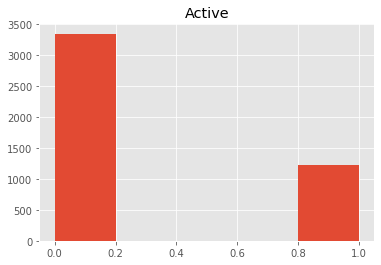

In [167]:
df_user['Active'].to_frame().hist(bins = 5)

array([[<AxesSubplot:title={'center':'Active'}>]], dtype=object)

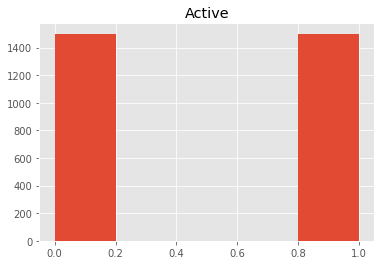

In [168]:
# Manually make the dataset balance by resampling
df_user = df_user.groupby("Active").sample(n=1500, random_state=42,replace=True)
df_user['Active'].to_frame().hist(bins = 5)

# Classification Task
    Step 1: Split the data
    Step 2: Train models
    Step 3: Evaluate Models

In [197]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
X = df_user.drop(columns=['Avg_Cli','userId','Active'])
y = df_user['Active']

from sklearn.model_selection import train_test_split as tr_te_split
X_train,X_test,y_train,y_test = tr_te_split(X,y,test_size=0.3)

In [198]:
# Define learning curve to check for overfitting
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator,title,X,y,axes=None,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
        axes.set_xlabel("Training examples")
        axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")


    
    return plt

### Logistic Regression Model (Baseline Model)

In [199]:
# Fit a Baseline Model with all features
# Logistic Regression as Classification
from sklearn.linear_model import LogisticRegression as LogitReg
LR=LogitReg(max_iter=10000).fit(X_train,y_train)

prob_pred=LR.predict_proba(X_test)
y_pred=list(map(lambda x: int(x>=0.5),prob_pred[:,1]))
accuracy_LR = LR.score(X_test,y_test)
print("AUC",accuracy_LR)

AUC 0.5544444444444444


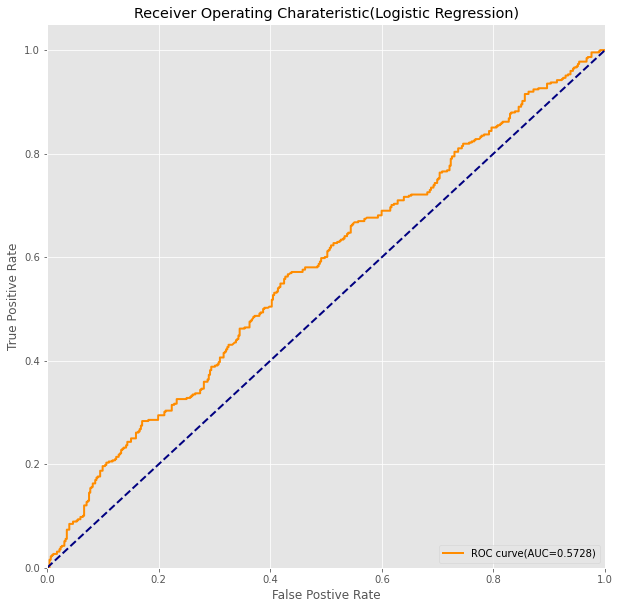

In [200]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve
fpr,tpr,thresholds = roc_curve(y_test,prob_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(Logistic Regression)')
plt.legend(loc='lower right')

Mean Accuracy: 0.565 (0.016)


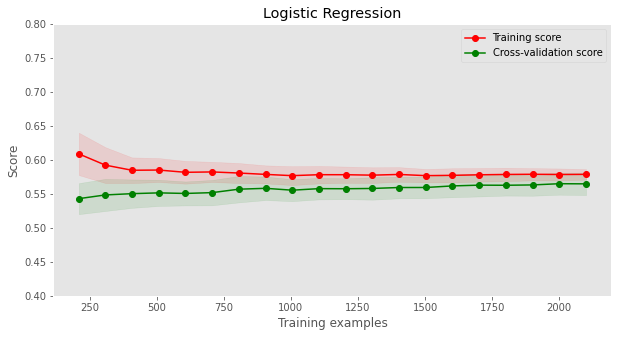

23.136533230001078 seconds


In [201]:
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import timeit
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)

fig, axes = plt.subplots(figsize=(10, 5))
title = "Logistic Regression"
estimator = LogitReg(max_iter=10000)
scores = cross_val_score(estimator, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
start = timeit.default_timer()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.4,0.8), cv=cv, n_jobs=4)
stop = timeit.default_timer()
plt.show()
print(stop - start, "seconds")

* Logistic Regression Analysis

- Our Logistic regression has a low AUC of 0.55. By definition, it means that given one random positive outcome and one random negative outcome, the probability (AUC) that this Logistic Regression Model correctly predicts which outcome is postive and which outcome is negative is only 0.55. 
In principal, a "random guess" classification model has a AUC of 0.5(As shown by the navy blue stragith line between (0,0) and (1,1)) so our model has not much edge over a pure random guess. 

- I choose Logistic regression as a start of the classification. As a model embedded with linear nature, the logistic regression highlights the tradeoff between different features of interest. 
The relative weight of the features can be captured by the ratio between their coefficients and therefore it draws a rough picture about the relative significance level of them. Based on the coefficient table from Linear regression, we may think of shortlisting the feature and see if dropping some less significant features help improve the model.

- The estimated coefficients of the logistic regression model to predict users' clicking probability are shown on Table(). From here, we learn that the average probability of user clicking into the creators' personal homepage, clicking "likes" have almost no benefit in help predicting the future clicking possibility, whereas users' action of "viewing comment" has a strong predictive power of the target. Then, our next step could be running the same model on less features.

- According to the learning curve, the model is suffer from underfitting since both the training and cross-validation score are low. And therefore, there's no need to apply regularization. We should admit that logistic regression is a bad model for the current task, in other words, the logistic regression fails to capture to true underlying relationship of future clicking probability and past actions.

In [230]:
# store the coefficients
df_coeff = pd.DataFrame({
    'Feature':df_user.columns.to_list()[2:15],
    'Coefficient': np.array(LR.coef_).reshape(13)
})

df_coeff

,Feature,Coefficient
0,Avg_IPH,0.356238
1,Avg_Com,0.000000
2,Avg_S,0.027043
3,Avg_VC,1.889200
4,Avg_L,0.840755
5,Avg_View_Time,0.004239
6,Age,-0.037775
7,G_female,0.329917
8,G_male,-0.180107
9,G_U,0.256330


In [234]:
df_coeff = df_coeff.sort_values(by=['Coefficient'], ascending=False)

In [235]:
print(df_coeff['Feature'])

3            Avg_VC
4             Avg_L
0           Avg_IPH
7          G_female
9               G_U
2             Avg_S
10            Level
5     Avg_View_Time
1           Avg_Com
11        followCnt
12          R_Month
6               Age
8            G_male
Name: Feature, dtype: object


Surprisingly, the feature "Average View Time" has the lowest predictive power among all. In all the users with more than 2 records

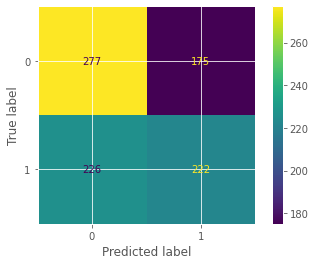

In [203]:
# Visualizing Confusion Matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
cm = confusion_matrix(y_test,y_pred,labels = LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LR.classes_)
disp.plot()
plt.show()

Baseline Dummy model for logistic Regression (If Accurcy is bigger than the model, the the model makes no sense)

In [204]:
from sklearn.dummy import DummyClassifier
most_fre_CL=DummyClassifier(strategy='most_frequent')
most_fre_CL.fit(X_train,y_train)
prob_pred=most_fre_CL.predict_proba(X_test)


prob_test=most_fre_CL.predict_proba(X_test)
y_pred_test=list(map(lambda x: int(x>=0.7),prob_test[:,1]))

accuracy_2 = most_fre_CL.score(X_test,y_test)
print("accuracy_2",accuracy_2)


accuracy_2 0.49777777777777776


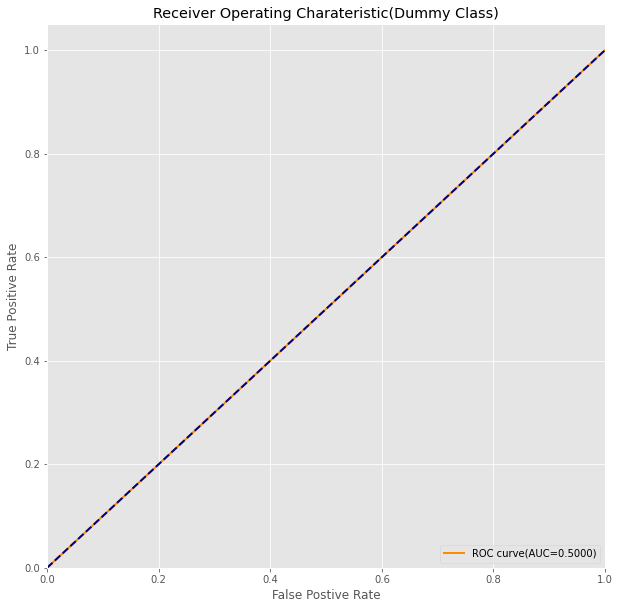

In [205]:
fpr,tpr,thresholds = roc_curve(y_test,prob_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(Dummy Class)')
plt.legend(loc='lower right')

Besides the normal logistic regression, a dummy logistic regression model is also applied to assure the ____ of our logistic regression
It is the model that only predicts one target, no matter what the inputs are. The rationale behind the comparison is that even though the single AUC of a normal logistic regression may looks good, it still cannot assure the model is satisfying if the classifier that only predicts one outcome have a similar AUC. This normally happen if the dataset is extremly unbalanced. 


As described in the dataset distribution section, most of the users do log in the platform and listen to music, but not much of them tend to click on the recommendation card and keep vie


In my first trial, the comparison provides 
Dummy logistic regression provide a baseline assesment of the logisticregression model we 
By testing on a dummy model,

### KNN

k = 100

In [206]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

scaler_p = StandardScaler().fit(X)
df_user_2 = df_user.drop(columns = ['Avg_Cli','userId','Active'])
df_user_2 = scaler_p.transform(df_user_2)

X_st=scaler_p.transform(X)

knn = KNeighborsClassifier(n_neighbors=50).fit(X_train_st,y_train)
y_pred = knn.predict(X_test_st)

accuracy_knn = knn.score(X_test_st,y_test)
print("accuracy_knn",accuracy_knn)

accuracy_knn 0.5555555555555556


The out-of-sample AUC for the 1nn is 0.5814


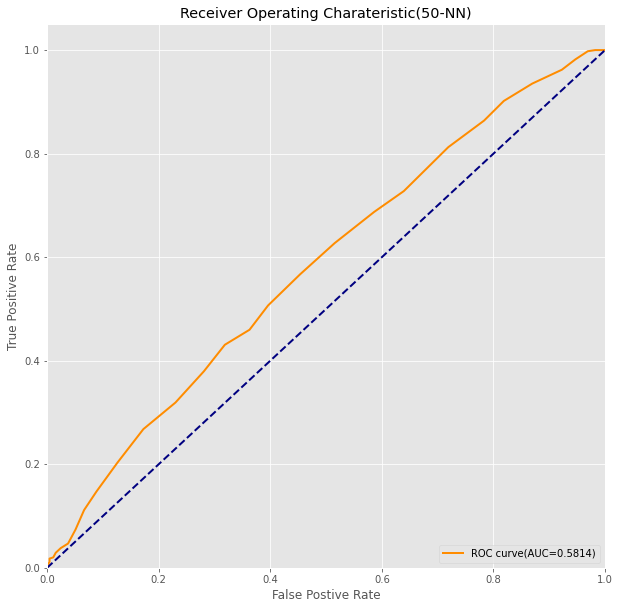

In [207]:
y_score =knn.predict_proba(X_test_st)
fpr,tpr,thresholds = roc_curve(y_test,y_score[:,1])
roc_auc = auc(fpr,tpr)

print("The out-of-sample AUC for the 1nn is %0.4f" % roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(50-NN)')
plt.legend(loc='lower right')


k = 1

In [208]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

scaler_p = StandardScaler().fit(X)
df_user_2 = df_user.drop(columns = ['Avg_Cli','userId','Active'])
df_user_2 = scaler_p.transform(df_user_2)

X_st=scaler_p.transform(X)

knn_1 = KNeighborsClassifier(n_neighbors=1).fit(X_train_st,y_train)
y_pred = knn.predict(X_test_st)

accuracy_knn = knn_1.score(X_test_st,y_test)
print("accuracy_knn",accuracy_knn)

accuracy_knn 0.7422222222222222


The out-of-sample AUC for the 1nn is 0.7424


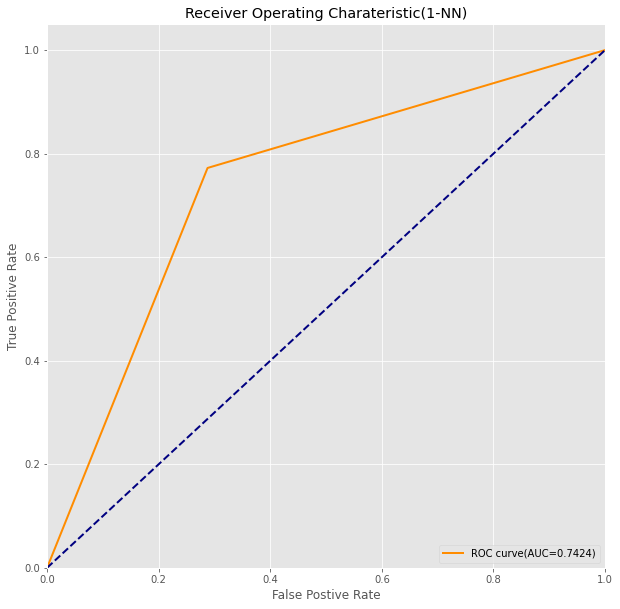

In [209]:
y_score =knn_1 .predict_proba(X_test_st)
fpr,tpr,thresholds = roc_curve(y_test,y_score[:,1])
roc_auc = auc(fpr,tpr)

print("The out-of-sample AUC for the 1nn is %0.4f" % roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(1-NN)')
plt.legend(loc='lower right')


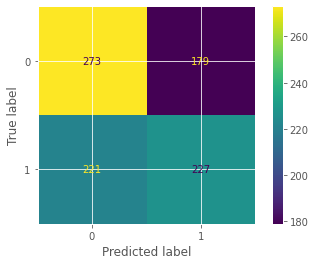

In [210]:
# Visualizing Confusion Matrix
tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
cm = confusion_matrix(y_test,y_pred,labels = knn_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn_1.classes_)
disp.plot()
plt.show()

k=2

In [211]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

scaler_p = StandardScaler().fit(X)
df_user_2 = df_user.drop(columns = ['Avg_Cli','userId','Active'])
df_user_2 = scaler_p.transform(df_user_2)

X_st=scaler_p.transform(X)

knn_2 = KNeighborsClassifier(n_neighbors=2).fit(X_train_st,y_train)
y_pred = knn.predict(X_test_st)

accuracy_knn = knn_2.score(X_test_st,y_test)
print("accuracy_knn_2",accuracy_knn)

accuracy_knn_2 0.6733333333333333


The out-of-sample AUC for the 1nn is 0.7272


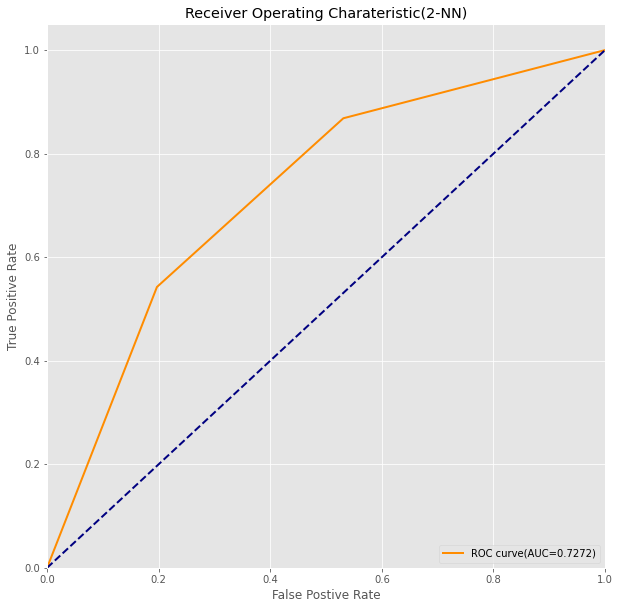

In [212]:
y_score =knn_2 .predict_proba(X_test_st)
fpr,tpr,thresholds = roc_curve(y_test,y_score[:,1])
roc_auc = auc(fpr,tpr)

print("The out-of-sample AUC for the 1nn is %0.4f" % roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(2-NN)')
plt.legend(loc='lower right')


Mean Accuracy: 0.737 (0.014)


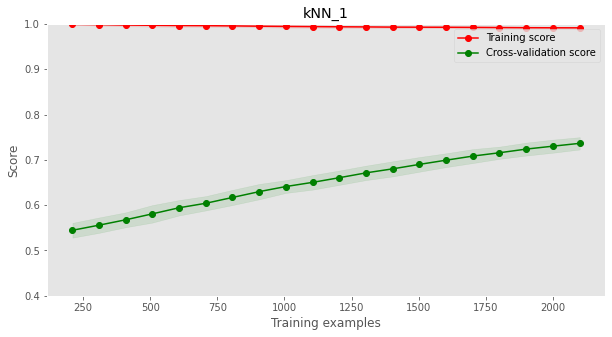

25.026415755000926 seconds


In [213]:
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)
fig, axes = plt.subplots(figsize=(10, 5))
title = "kNN_1"
estimator = knn_1
scores = cross_val_score(estimator, X_st, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
start = timeit.default_timer()
plot_learning_curve(estimator, title, X_st, y, axes=axes, ylim=(0.4,1), cv=cv, n_jobs=4)
stop = timeit.default_timer()
plt.show()
print(stop - start, "seconds")

k- Nearest Neighbor(k-NN) model is also a widely used model for classification. This model estimates P[Y=1|X] directly and builds a classifer by local averaging. The key assumption of the k-NN model is that the distance in the feature space reliably reflects similarities in the outcomes.

### Decision Tree

The out-of-sample AUC for Decision Tree is 0.7254


[Text(442.6588557208026, 534.5400000000001, 'X[5] <= 0.07\ngini = 0.5\nsamples = 2100\nvalue = [1048, 1052]'),
 Text(352.2428416499385, 516.4200000000001, 'X[7] <= 0.5\ngini = 0.487\nsamples = 1500\nvalue = [869, 631]'),
 Text(297.80802126284, 498.3, 'X[11] <= 58.5\ngini = 0.473\nsamples = 1129\nvalue = [695, 434]'),
 Text(276.14382030345774, 480.18, 'X[6] <= 27.5\ngini = 0.481\nsamples = 978\nvalue = [584, 394]'),
 Text(250.03764060691552, 462.06, 'X[6] <= 26.5\ngini = 0.483\nsamples = 960\nvalue = [568, 392]'),
 Text(207.0104663990162, 443.94, 'X[6] <= 22.5\ngini = 0.481\nsamples = 945\nvalue = [564, 381]'),
 Text(130.4283402054398, 425.82000000000005, 'X[12] <= 31.5\ngini = 0.487\nsamples = 846\nvalue = [492, 354]'),
 Text(30.00714337384259, 407.70000000000005, 'X[6] <= 18.5\ngini = 0.495\nsamples = 560\nvalue = [307, 253]'),
 Text(5.7407407407407405, 389.58000000000004, 'X[11] <= 4.5\ngini = 0.41\nsamples = 59\nvalue = [42, 17]'),
 Text(2.2962962962962963, 371.46000000000004, 'X[10

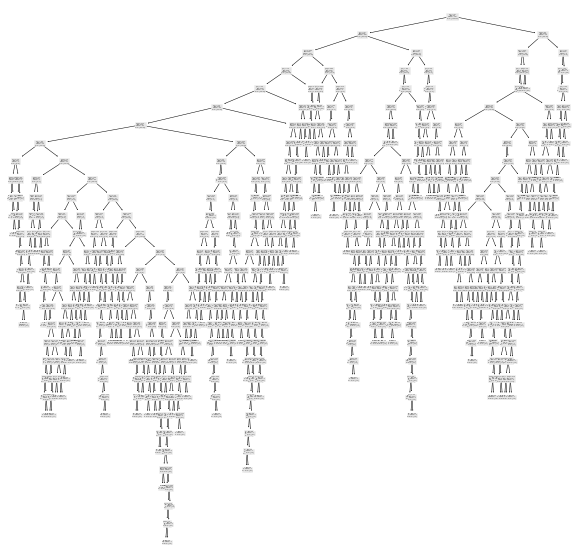

In [214]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth= 1000)
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)

y_score =tree.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_score[:,1])
roc_auc = auc(fpr,tpr)

print("The out-of-sample AUC for Decision Tree is %0.4f" % roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(Decision Tree)')
plt.legend(loc='lower right')

from sklearn.tree import plot_tree
plot_tree(tree)

The out-of-sample AUC for Decision Tree is 0.7287


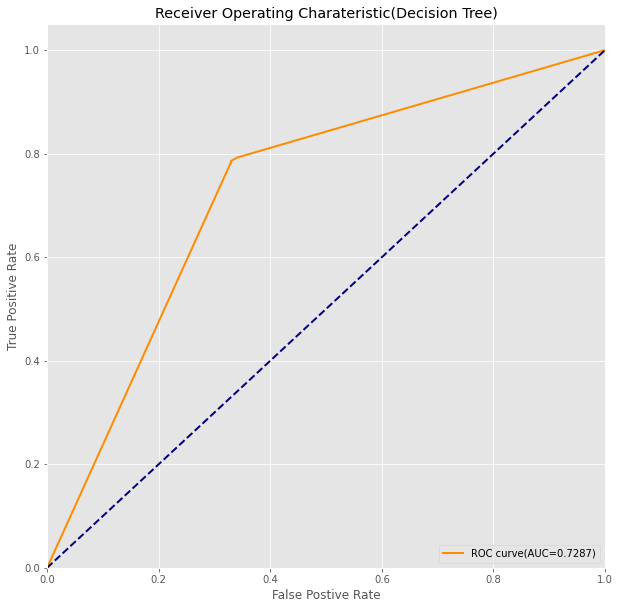

In [215]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth= 10000)
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)

y_score =tree.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_score[:,1])
roc_auc = auc(fpr,tpr)

print("The out-of-sample AUC for Decision Tree is %0.4f" % roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(Decision Tree)')
plt.legend(loc='lower right')



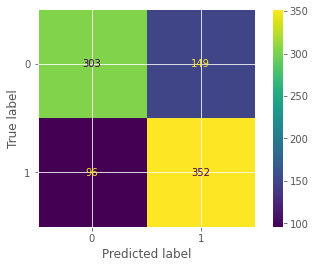

In [216]:
# Visualizing Confusion Matrix
tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
cm = confusion_matrix(y_test,y_pred,labels = tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tree.classes_)
disp.plot()
plt.show()

Mean Accuracy: 0.744 (0.017)


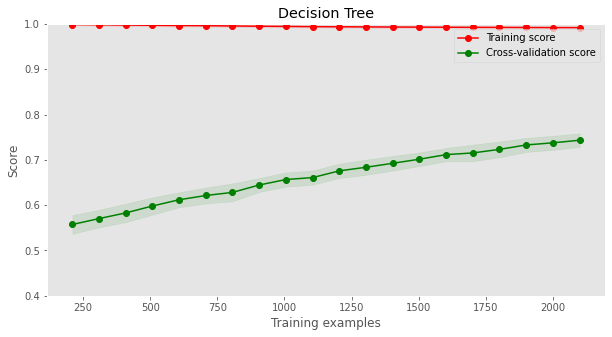

6.793751130000601 seconds


In [217]:
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)
fig, axes = plt.subplots(figsize=(10, 5))
title = "Decision Tree"
estimator = tree
scores = cross_val_score(estimator, X_st, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
start = timeit.default_timer()
plot_learning_curve(estimator, title, X_st, y, axes=axes, ylim=(0.4,1), cv=cv, n_jobs=4)
stop = timeit.default_timer()
plt.show()
print(stop - start, "seconds")

### Random Forest

accuracy_Random Forest 0.7655555555555555
The out-of-sample AUC for the Random Forest is 0.8488


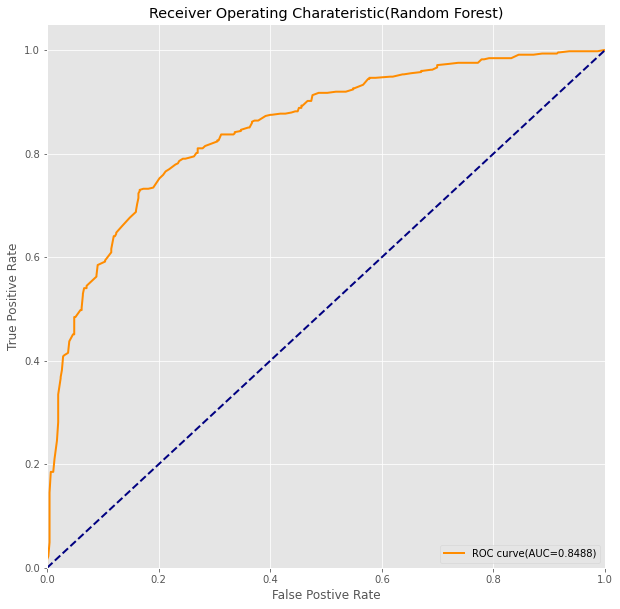

In [218]:
from sklearn.ensemble import RandomForestClassifier

Forest_cli = RandomForestClassifier(n_estimators = 100)
Forest_cli.fit(X_train,y_train)
y_pred=Forest_cli.predict(X_test)

accuracy_RandomForest = Forest_cli.score(X_test,y_test)
print("accuracy_Random Forest",accuracy_RandomForest)

y_score =Forest_cli .predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_score[:,1])
roc_auc = auc(fpr,tpr)

print("The out-of-sample AUC for the Random Forest is %0.4f" % roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(Random Forest)')
plt.legend(loc='lower right')

In [228]:
df_coeff_rf = pd.DataFrame({
    'Feature':df_user.columns.to_list()[2:15],
    'Importance': Forest_cli.feature_importances_
})

df_coeff_rf.style.hide_index()

# The feature_importance report the average amount of decrease in Gini index associated with the split on different features used to train the random forest. The larger the decrease, the more important the feature.
# As we can see from the results, for the random forest model, the feature        makes the most important contribution to predicting the future clicking probability.


Feature,Importance
Avg_IPH,0.000767
Avg_Com,0.000000
Avg_S,0.001072
Avg_VC,0.019471
Avg_L,0.006111
Avg_View_Time,0.122932
Age,0.122998
G_female,0.015604
G_male,0.013259
G_U,0.005603


In [229]:
importances = Forest_cli.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
print(*X_train.columns[sorted_indices], sep = "\n")

followCnt
R_Month
Age
Avg_View_Time
Level
Avg_VC
G_female
G_male
Avg_L
G_U
Avg_S
Avg_IPH
Avg_Com


Mean Accuracy: 0.762 (0.014)


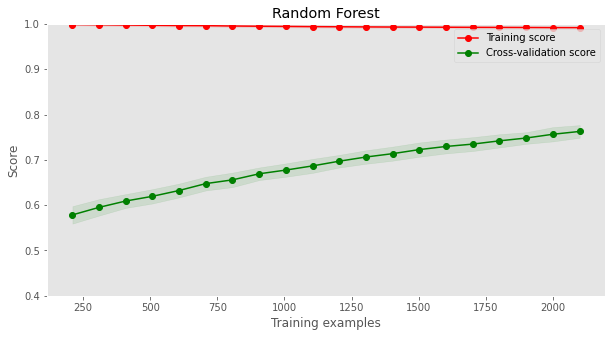

73.2779484299972 seconds


In [220]:
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)
fig, axes = plt.subplots(figsize=(10, 5))
title = "Random Forest"
estimator = Forest_cli
scores = cross_val_score(estimator, X_st, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
start = timeit.default_timer()
plot_learning_curve(estimator, title, X_st, y, axes=axes, ylim=(0.4,1), cv=cv, n_jobs=4)
stop = timeit.default_timer()
plt.show()
print(stop - start, "seconds")

### XgBoost

[19:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy_xgbt 0.7733333333333333
The out-of-sample AUC for the XGBT is 0.8076


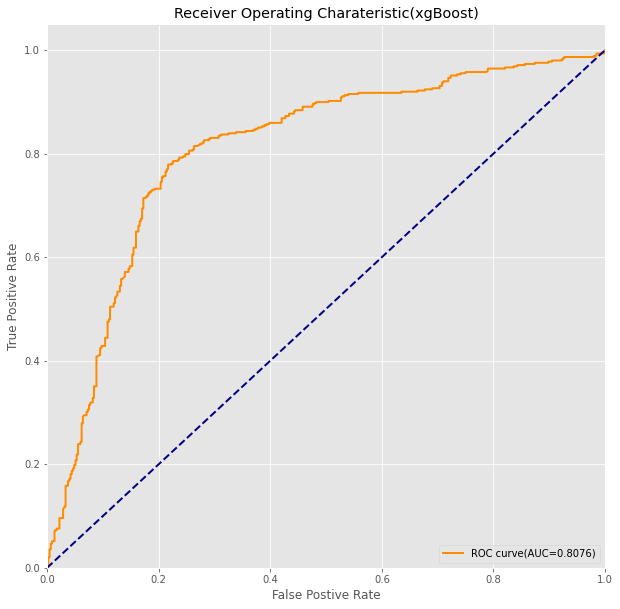

In [221]:
import xgboost as xgb
data_train=xgb.DMatrix(data=X_train,label=y_train)
data_test=xgb.DMatrix(data=X_test,label=y_test)

xgbt=xgb.XGBClassifier(n_estimators = 1000).fit(X_train,y_train)
y_pred=xgbt.predict(X_test)

accuracy_xgbt = xgbt.score(X_test,y_test)
print("accuracy_xgbt",accuracy_xgbt)

y_score = xgbt.predict_proba(X_test)
fpr,tpr,thresholds = roc_curve(y_test,y_score[:,1])
roc_auc = auc(fpr,tpr)

print("The out-of-sample AUC for the XGBT is %0.4f" % roc_auc)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color = 'darkorange',lw =2, label = 'ROC curve(AUC=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1],color = 'navy',lw=2,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charateristic(xgBoost)')
plt.legend(loc='lower right')

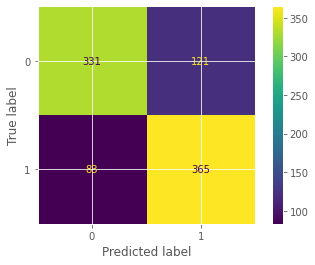

In [222]:
# Visualizing Confusion Matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
cm = confusion_matrix(y_test,y_pred,labels = xgbt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgbt.classes_)
disp.plot()
plt.show()

Accuracy: 77.33%


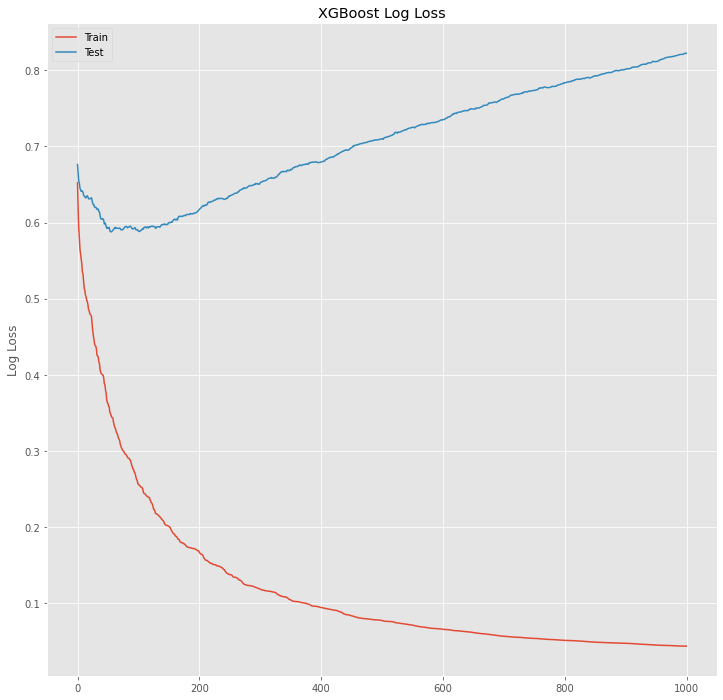

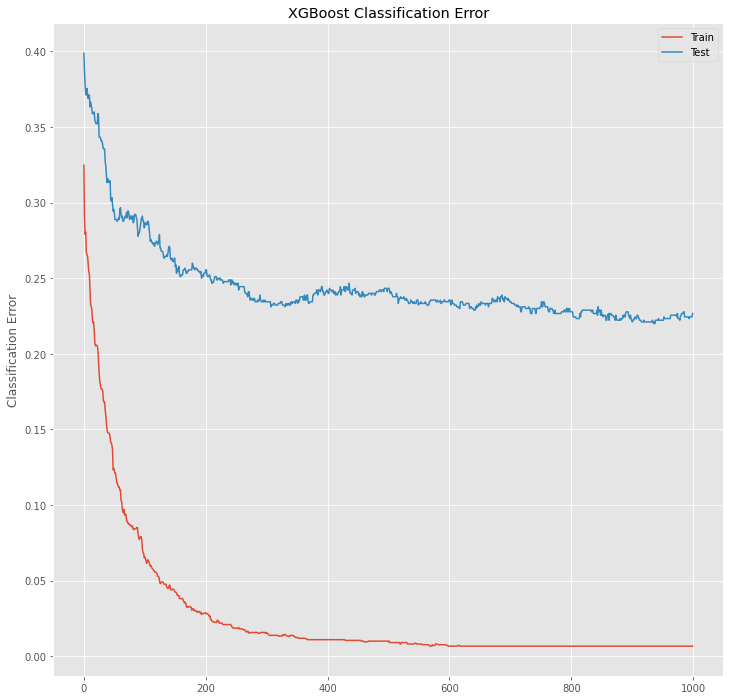

In [223]:
def Learning_curve_for_XGboost(): 
    import warnings
    warnings.filterwarnings("ignore")
    from matplotlib import pyplot
    import matplotlib.pyplot as plt 
    from numpy import loadtxt
    from sklearn.metrics import accuracy_score  
    plt.style.use('ggplot')    
    
    # fit model no training data
    model = xgbt
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = pyplot.subplots(figsize=(12,12))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    
    
    # plot classification error
    fig, ax = pyplot.subplots(figsize=(12,12))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()
Learning_curve_for_XGboost()

Method:

In general, boosting algorithm takes a group of weak classifiers(e.g. decision stumps) and add them into a strong classifier while reweighting their contribution. Meanwhile, each weak classifer focus more on the data points that are incorrectly classified by the preceeding weak classifier.

In core, a gradient boosting tree adaptively train a series of simple decision trees and transform them into a strong tree with the objective to minimize the sum of the total training loss and the total regularization penalty. The extreme gradient boosting tree (XGBT) is normally expected to more accurate than random forest.


xgboost provides the most satisfying result among all models with an out-of-sample AUC of 0.7935. 

### Gaussian Naive Bayes

Mean Accuracy: 0.519 (0.015)


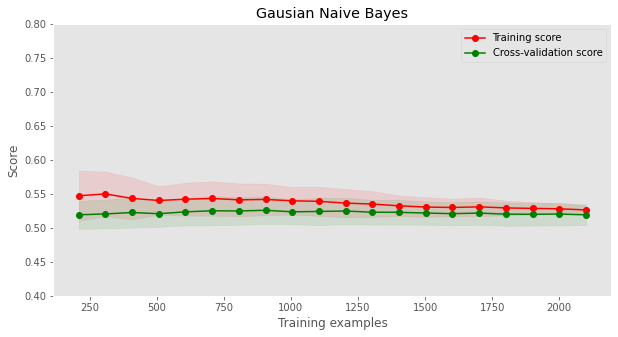

7.650139105000562 seconds


In [224]:
from sklearn.naive_bayes import GaussianNB

cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)
fig, axes = plt.subplots(figsize=(10, 5))
title = "Gausian Naive Bayes"
estimator = GaussianNB()
scores = cross_val_score(estimator, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
start = timeit.default_timer()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.4,0.8), cv=cv, n_jobs=4)
stop = timeit.default_timer()
plt.show()
print(stop - start, "seconds")

# Compare with deep learning OR neural Network